## importing required libraries

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import struct
import numpy as np
import numpy
import random
import tensorflow as tf
import os
import pickle as pickle
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
#this function helps to visualize the dict
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
# take(1, prod_desc.values())

## procedure to load the data from the json format to rating matrix

In [3]:
# load data after creating features
def load_data_hybrid(data_path, min_items=2, min_users=2, sampling= True, sample_size = 0.5):
    user_ratings = defaultdict(set)
    item_ratings = defaultdict(set)
    max_u_id = -1
    max_i_id = -1
    user_count = 0
    item_count = 0
    reviews = 0
    users = {}  # aid to id LUT
    items = {}  # asid to id LUT
    records = {} # all records
    features = {}
    random.seed(0)
    columns = None
    offset_to_features = 3
    with open(data_path, 'r') as f:
        bad_actor = 0
        for line in f.readlines():
            record = {}
            split_line = line.split(",")
            if columns is None:
                columns = [e.rstrip() for e in split_line]
                continue
            if (sampling and random.random()>sample_size):
                continue
            reviews += 1
            
            if (len(split_line) > len(columns)):
                bad_actor = bad_actor + 1
                continue
            else:
                auid, asid, _ = split_line[0:offset_to_features]
                record = {columns[i]:split_line[i].rstrip() for i in  range (offset_to_features, len(split_line))}

            u, i = None, None

            if auid in users:
                u = users[auid]
            else:
                user_count += 1  # new user so increment
                users[auid] = user_count
                u = user_count
            
            if asid in items:
                i = items[asid]
            else:
                item_count += 1  # new i so increment
                items[asid] = item_count
                i = item_count
                records[i] = record
                if record['price'] == '':
                    records[i]['price'] = 0
                else:
                    records[i]['price'] = float(record['price'])
                    
                if len(record['feature_vector']) == 0:
                    records[i]['feature_vector'] = list(np.zeros(4524))
                else:
                    records[i]['feature_vector'] = [int(el) for el in list(record['feature_vector'])[:-1][1:]]
    
                for c in ['feature_vector','top_categories_hotencoded','price_percentile_encoded','season_meteorological_encoded']:
                    records[i][c] = [int(el) for el in list(record[c])[:-2][1:]] 
            
            user_ratings[u].add(i)
            item_ratings[i].add(u)
            max_u_id = max(u, max_u_id)
            max_i_id = max(i, max_i_id)
            
    print ("max_u_id: ", max_u_id)
    print ("max_i_id: ", max_i_id)
    print ("reviews : ", reviews)


    # filter out users w/ less than X reviews
    num_u_id = 0
    num_i_id = 0
    num_reviews = 0
    user_ratings_filtered = defaultdict(set)
    for u, ids in user_ratings.items():
        if len(ids) > min_items:
            user_ratings_filtered[u] = ids
            num_u_id += 1
            num_reviews += len(ids)
            
    item_ratings_filtered = defaultdict(set)
    for ids, u in item_ratings.items():
        if len(u) > min_users:
            # keep
            item_ratings_filtered[ids] = u
            num_i_id += 1
    
    feature_keys = records[1].keys() #should be same as columns[offset:]
    features = {k:{i:records[i][k] for i in range(1,len(records)+1)} for k in feature_keys}

    print ("u_id: ", num_u_id)
    print ("i_id: ", num_i_id)
    print ("reviews : ", num_reviews)
    #return max_u_id, max_i_id, users, items, user_ratings_filtered,\
    #            item_ratings_filtered, brands, prices, prod_desc, prod_cat,price_feature,season_feature
    return max_u_id, max_i_id, users, items, user_ratings_filtered,item_ratings_filtered, features

## Procedure to load image features of the products

In [4]:
#load image features for the given asin collection into dictionary
def load_image_features(path, items):
    count=0
    image_features = {}
    f = open(path, 'rb')
    while True:
        asin = f.read(10)
        if asin == '': break
        features_bytes = f.read(16384) # 4 * 4096 = 16KB, fast read, don't unpack
  
        if asin in items: #only unpack 4096 bytes if w need it -- big speed up
            features = (np.fromstring(features_bytes, dtype=np.float32)/58.388599)
            iid=items[asin]
            if len(features)==0:
                image_features[iid] = np.zeros(4096)
            else:
                image_features[iid] = features
    
    return image_features

## Procedure to uniformly sample the (u,i,j) triplet from the raw data for the train set

In [5]:
def uniform_sample_batch(train_ratings, test_ratings, item_count, advanced_features):
    neg_items = 2
    for u in train_ratings.keys():
        t = []
        iv = []
        jv = []
        for i in train_ratings[u]:
            if (u in test_ratings.keys()):
                if (i != test_ratings[u]):  # make sure it's not in the test set
                    for k in range(1,neg_items):
                        j = random.randint(1, item_count)
                        while j in train_ratings[u]:
                            j = random.randint(1, item_count)
                        # sometimes there will not be an image for given product
                        try:
                            advanced_features[i]
                            advanced_features[j]
                        except KeyError:
                            continue
                        iv.append(advanced_features[i])
                        jv.append(advanced_features[j])
                        t.append([u, i, j])
            else:
                for k in range(1,neg_items):
                    j = random.randint(1, item_count)
                    while j in train_ratings[u]:
                        j = random.randint(1, item_count)
                    # sometimes there will not be an image for given product
                    try:
                        advanced_features[i]
                        advanced_features[j]
                    except KeyError:
                        continue
                    iv.append(advanced_features[i])
                    jv.append(advanced_features[j])
                    t.append([u, i, j])

        # block if queue is full
        if len(iv)>1:
            yield numpy.asarray(t), numpy.vstack(tuple(iv)), numpy.vstack(tuple(jv))
        else:
            continue

## Procedure to uniformly sample the (u,i,j) triplet from the raw data for the test set

In [6]:
def test_batch_generator_by_user(train_ratings, test_ratings, item_ratings, item_count, advanced_features, cold_start = False, cold_start_thresh = 5):
    # using leave one cv
    for u in random.sample(test_ratings.keys(), 4000):
    #for u in test_ratings.keys():
        i = test_ratings[u]
        if (cold_start and len(item_ratings[i]) > cold_start_thresh-1):
            continue
        t = []
        ilist = []
        jlist = []
        count = 0
        for j in random.sample(range(item_count), 100):
            # find item not in test[u] and train[u]
            if j != test_ratings[u] and not (j in train_ratings[u]):
                try:
                    advanced_features[i]
                    advanced_features[j]
                except KeyError:
                    continue

                count += 1
                t.append([u, i, j])
                ilist.append(advanced_features[i])
                jlist.append(advanced_features[j])

        # print numpy.asarray(t).shape
        # print numpy.vstack(tuple(ilist)).shape
        # print numpy.vstack(tuple(jlist)).shape
        if (len(ilist) == 0):
            #print "could not find neg item for user, count: ", count, u
            continue
        yield numpy.asarray(t), numpy.vstack(tuple(ilist)), numpy.vstack(tuple(jlist))

## Procedure to generate the (u,i) pair for the test data

In [7]:
def generate_test(user_ratings):
    '''
    for each user, random select one rating into test set
    '''
    user_test = dict()
    for u, i_list in user_ratings.items():
        user_test[u] = random.sample(user_ratings[u], 1)[0]
    return user_test

## performs transformations and/or necessary hot encoding

In [8]:
#user_count, item_count, users, items, user_ratings, item_ratings, brands, prices, prod_desc = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
def transform_features (features):
    if 'price' in features:
        prices = features['price']

        prices_features= {}
        prices_all = list(set(prices.values()))
        price_quant_level = 10
        price_max = float(max(prices.values()))
        for key, value in prices.items():
            prices_vec = numpy.zeros(price_quant_level+1)
            idx = int(numpy.ceil(float(value)/(price_max/price_quant_level)))
            prices_vec[idx]=1
            prices_features[key] = prices_vec
        features['price'] = prices_features
    if 'brand' in features:
        brands_features = {}
        brands = loaded_features['brand']
        brands_all = list(set(brands.values()))
        for key, value in brands.items():
            brands_vec = numpy.zeros(len(brands_all))
            brands_vec[brands_all.index(value)] = 1
            brands_features[key] = brands_vec
        features['brand'] = brands_features
        
    return features

## function to combine features

In [9]:
# list of features defined as dicts can be passed and they are combined, if none array of zeros are created

def feature_set(feature_dicts=None):
    if feature_dicts!=None:
        combined_features = defaultdict(list)
        for d in feature_dicts:
            for k, v in d.items():  
                combined_features[k].extend(v)

        return dict([(k,v) for k,v in combined_features.items()])
    
    else:
        
        return {n: [0] for n in range(1,item_count+1)} #return just zeros dummy advanced features for baseline BPR

## Bayesian Personalized Ranking (BPR) Model and it's extensions (VBPR, NVBPR, Hybrid)

In [10]:
def abpr(user_count, item_count, advanced_features, hidden_dim=10, hidden_img_dim=10,
         l2_regulization=0.1,
         bias_regulization=0.01,
         embed_regulization = 0,
         image_regulization =0.1,
         visual_bias_regulization = 0.01):
    """
    user_count: total number of users
    item_count: total number of items
    hidden_dim: hidden feature size of MF
    hidden_img_dim: hidden visual/non-visual feature size of MF
    """
    advanced_feat_dim = len(advanced_features[1])
    iv = tf.placeholder(tf.float32, [None, advanced_feat_dim])
    jv = tf.placeholder(tf.float32, [None, advanced_feat_dim])
    u = tf.placeholder(tf.int32, [None])
    i = tf.placeholder(tf.int32, [None])
    j = tf.placeholder(tf.int32, [None])
    
    # model parameters -- LEARN THESE
    # latent factors
    user_emb_w = tf.get_variable("user_emb_w", [user_count + 1, hidden_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
    item_emb_w = tf.get_variable("item_emb_w", [item_count + 1, hidden_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
    # biases
    item_b = tf.get_variable("item_b", [item_count + 1, 1], initializer=tf.constant_initializer(0.0))

    # pull out the respective latent factor vectors for a given user u and items i & j
    u_emb = tf.nn.embedding_lookup(user_emb_w, u)
    i_emb = tf.nn.embedding_lookup(item_emb_w, i)
    j_emb = tf.nn.embedding_lookup(item_emb_w, j)
    
    # get the respective biases for items i & j
    i_b = tf.nn.embedding_lookup(item_b, i)
    j_b = tf.nn.embedding_lookup(item_b, j)


    # MF predict: u_i > u_j
   
    # UxD visual factors for users
    user_img_w = tf.get_variable("user_img_w", [user_count + 1, hidden_img_dim],
                             initializer=tf.random_normal_initializer(0, 0.1))
    # this is E, the embedding matrix
    img_emb_w = tf.get_variable("img_emb_w", [hidden_img_dim, advanced_feat_dim],
                            initializer=tf.random_normal_initializer(0, 0.1))

    theta_i = tf.matmul(iv, img_emb_w, transpose_b=True)  # (f_i * E), eq. 3
    theta_j = tf.matmul(jv, img_emb_w, transpose_b=True)  # (f_j * E), eq. 3

    visual_bias = tf.get_variable("visual_bias", [1, advanced_feat_dim], initializer=tf.random_normal_initializer(0, 0.1))
    # pull out the visual factor, 1 X D for user u

    u_img = tf.nn.embedding_lookup(user_img_w, u)

    xui = i_b + tf.reduce_sum(tf.multiply(u_emb, i_emb), 1, keep_dims=True) + tf.reduce_sum(tf.multiply(u_img, theta_i), 1, keep_dims=True) \
                                                                        + tf.reduce_sum(tf.multiply(visual_bias, iv), 1, keep_dims=True) 
    xuj = j_b + tf.reduce_sum(tf.multiply(u_emb, j_emb), 1, keep_dims=True) + tf.reduce_sum(tf.multiply(u_img, theta_j), 1, keep_dims=True) \
                                                                        + tf.reduce_sum(tf.multiply(visual_bias, jv), 1, keep_dims=True) 
    l2_norm = tf.add_n([
        l2_regulization * tf.reduce_sum(tf.multiply(u_emb, u_emb)),
        image_regulization * tf.reduce_sum(tf.multiply(u_img, u_img)),
        l2_regulization * tf.reduce_sum(tf.multiply(i_emb, i_emb)),
        l2_regulization * tf.reduce_sum(tf.multiply(j_emb, j_emb)),
        embed_regulization * tf.reduce_sum(tf.multiply(img_emb_w, img_emb_w)),
        bias_regulization * tf.reduce_sum(tf.multiply(i_b, i_b)),
        bias_regulization * tf.reduce_sum(tf.multiply(j_b, j_b)),
        visual_bias_regulization * tf.reduce_sum(tf.multiply(visual_bias, visual_bias))
    ])
        
    xuij = xui - xuj

    auc = tf.reduce_mean(tf.to_float(xuij > 0))
    
    loss = l2_norm - tf.reduce_mean(tf.log(tf.sigmoid(xuij)))
    
    train_op = tf.train.AdamOptimizer().minimize(loss)
    
    return u, i, j, iv, jv, loss, auc, train_op

## Procedure to run the end-to-end model (from loading data to training the model and to test the model)

In [33]:
def session_run(num_iter, user_count, item_count, users, items, user_ratings, item_ratings, advanced_features):
    ### Loading and parsing the review matrix for Women 5-core dataset
    auc_train = []
    auc_test = []
    auc_test_cs = []
    #data_path = os.path.join('/Users/nolanthomas/Public/amazon', 'out_topcategories_pricepercentile_seasonmeteorological.csv')
    #user_count, item_count, users, items, user_ratings, item_ratings, brands, features = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
    user_ratings_test = generate_test(user_ratings)
    with tf.Graph().as_default(), tf.Session() as session:
        with tf.variable_scope('abpr'):
            u, i, j, iv, jv, loss, auc, train_op = abpr(user_count, item_count, advanced_features)

        session.run(tf.global_variables_initializer())
        

        for epoch in range(1, num_iter+1):
            print ("epoch ", epoch)
            _loss_train = 0.0
            user_count = 0
            auc_train_values = []
            for d, _iv, _jv in uniform_sample_batch(user_ratings, user_ratings_test, item_count, advanced_features):
                user_count += 1
                _loss, _auc, _ = session.run([loss, auc, train_op], feed_dict={u:d[:,0], i:d[:,1], j:d[:,2], iv:_iv, jv:_jv})
                _loss_train += _loss
                auc_train_values.append(_auc)
            print ("train_loss:", _loss_train/user_count, "train auc: ", numpy.mean(auc_train_values))
            auc_train.append(numpy.mean(auc_train_values))


            auc_values = []
            _loss_test = 0.0
            user_count = 0
            for d, _iv, _jv in test_batch_generator_by_user(user_ratings, user_ratings_test, item_ratings, item_count, advanced_features, cold_start = False):
                user_count += 1
                _loss, _auc = session.run([loss, auc], feed_dict={u: d[:, 0], i: d[:, 1], j: d[:, 2], iv: _iv, jv: _jv})
                _loss_test += _loss
                auc_values.append(_auc)
            print ("test_loss: ", _loss_test / user_count, "test auc: ", numpy.mean(auc_values))
            auc_test.append(numpy.mean(auc_values))

            auc_values_cs = []
            _loss_test_cs = 0.0
            user_count = 0
            for d, _iv, _jv in test_batch_generator_by_user(user_ratings, user_ratings_test, item_ratings, item_count, advanced_features, cold_start = True, cold_start_thresh = 10):
                user_count += 1
                _loss, _auc = session.run([loss, auc], feed_dict={u: d[:, 0], i: d[:, 1], j: d[:, 2], iv: _iv, jv: _jv})
                _loss_test_cs += _loss
                auc_values_cs.append(_auc)
            print ("cold start test_loss: ", _loss_test_cs / user_count, "cold start auc: ", numpy.mean(auc_values_cs))
            auc_test_cs.append(numpy.mean(auc_values_cs))
        return auc_train, auc_test, auc_test_cs

## Load and make transformations; reuse across sessions
#### 1. Load data
#### 2. Make transformations
#### 3. Run Session

In [12]:
data_path = os.path.join('/Users/nolanthomas/Public/amazon', 'out_topcategories_pricepercentile_seasonmeteorological.csv')
user_count, item_count, users, items, user_ratings, item_ratings, loaded_features   = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
loaded_features = transform_features(loaded_features)
len(take(1, loaded_features['brand'].values())[0])

max_u_id:  34506
max_i_id:  14765
reviews :  144992
u_id:  12300
i_id:  14765
reviews :  84208


1997

Results from prior notebook before modifications
* max_u_id:  34506
* max_i_id:  14765
* reviews :  144992
* u_id:  12300
* i_id:  14765
* reviews :  84208

## Running BASELINE BPR with no advanced features at all

In [24]:
# feature_set() is called without arguments
bpr_auc_train, bpr_auc_test, bpr_auc_test_cold_start = session_run(NUM_SESSIONS, user_count, item_count, users, items, user_ratings, item_ratings,feature_set())

epoch  1
train_loss: 0.830869392636 train auc:  0.621817
test_loss:  2.13729429233 test auc:  0.651222
cold start test_loss:  2.20699679475 cold start auc:  0.37633
epoch  2
train_loss: 0.715655924603 train auc:  0.695362
test_loss:  1.60563380416 test auc:  0.650458
cold start test_loss:  1.61602805669 cold start auc:  0.363721
epoch  3
train_loss: 0.662617552792 train auc:  0.709556
test_loss:  1.37871763399 test auc:  0.65465
cold start test_loss:  1.35833179544 cold start auc:  0.368045


## Trying one advanced feature at a time

### Option on how to pass feature

In [14]:
NUM_SESSIONS = 3

price_feature = loaded_features['price']
pbpr_auc_train, pbpr_auc_test, pbpr_auc_test_cold_start = session_run(NUM_SESSIONS, user_count, item_count, users, items, user_ratings, item_ratings, feature_set([price_feature]))

epoch  1
train_loss: 0.829307674644 train auc:  0.6092
test_loss:  2.14851935075 test auc:  0.655476
cold start test_loss:  2.22892408377 cold start auc:  0.388171
epoch  2
train_loss: 0.714799625311 train auc:  0.686845
test_loss:  1.63396886347 test auc:  0.660708
cold start test_loss:  1.6540036804 cold start auc:  0.381898
epoch  3
train_loss: 0.658199580901 train auc:  0.7154
test_loss:  1.50903911418 test auc:  0.655496
cold start test_loss:  1.48532178023 cold start auc:  0.406213


### Another option on passing features

In [15]:
pbpr_auc_train, pbpr_auc_test, pbpr_auc_test_cold_start = session_run(NUM_SESSIONS, user_count, item_count, users, items, user_ratings, item_ratings, feature_set([loaded_features['price']]))

epoch  1
train_loss: 0.829388213836 train auc:  0.61062
test_loss:  2.13831138471 test auc:  0.643846
cold start test_loss:  2.20781980737 cold start auc:  0.403563
epoch  2
train_loss: 0.714132271453 train auc:  0.690763
test_loss:  1.63799682888 test auc:  0.654921
cold start test_loss:  1.66400633323 cold start auc:  0.387663
epoch  3
train_loss: 0.655635385043 train auc:  0.716341
test_loss:  1.52665222916 test auc:  0.666423
cold start test_loss:  1.51194385001 cold start auc:  0.400375


In [16]:
#passing product category as feature
cbpr_auc_train, cbpr_auc_test, cbpr_auc_test_cold_start = session_run(NUM_SESSIONS, user_count, item_count, users, items, user_ratings, item_ratings, feature_set([loaded_features[c] for c in ['top_categories_hotencoded']]))

epoch  1
train_loss: 0.828661618899 train auc:  0.600166
test_loss:  2.23564011514 test auc:  0.652639
cold start test_loss:  2.3138395741 cold start auc:  0.45475
epoch  2
train_loss: 0.708361209745 train auc:  0.68493
test_loss:  1.84832430671 test auc:  0.669672
cold start test_loss:  1.87465499138 cold start auc:  0.464387
epoch  3
train_loss: 0.625313406476 train auc:  0.74673
test_loss:  1.77835095003 test auc:  0.703274
cold start test_loss:  1.77127248277 cold start auc:  0.546053


In [17]:
#passing product desc as a feature: this is the bigrams feature_vector
pdbpr_auc_train, pdbpr_auc_test, pdbpr_auc_test_cold_start = session_run(NUM_SESSIONS, user_count, item_count, users, items, user_ratings, item_ratings, feature_set([loaded_features[c] for c in ['feature_vector']]))

epoch  1
train_loss: 0.837310830267 train auc:  0.61125
test_loss:  2.2038413668 test auc:  0.641845
cold start test_loss:  2.28498003637 cold start auc:  0.403959
epoch  2
train_loss: 0.71294277605 train auc:  0.70884
test_loss:  1.77391110037 test auc:  0.662451
cold start test_loss:  1.80110791656 cold start auc:  0.393322
epoch  3
train_loss: 0.646260564085 train auc:  0.753838
test_loss:  1.67932536618 test auc:  0.676351
cold start test_loss:  1.67757528018 cold start auc:  0.410299


In [22]:
#passing brands_features as a feature
bbpr_auc_train, bbpr_auc_test, bbpr_auc_test_cold_start = session_run(NUM_SESSIONS, user_count, item_count, users, items, user_ratings, item_ratings, feature_set([loaded_features[c] for c in ['brand']]))

epoch  1
train_loss: 0.832408964867 train auc:  0.617335
test_loss:  2.16998555985 test auc:  0.650979
cold start test_loss:  2.24564994418 cold start auc:  0.397296
epoch  2
train_loss: 0.712925567494 train auc:  0.707151
test_loss:  1.69419200072 test auc:  0.667307
cold start test_loss:  1.70534827041 cold start auc:  0.391401
epoch  3
train_loss: 0.65359680201 train auc:  0.73867
test_loss:  1.58647619815 test auc:  0.674297
cold start test_loss:  1.56630749173 cold start auc:  0.413734


## Price and Category

In [23]:
#combining price and product category feature : features you want to pass is always passed as a list
pcatbpr_auc_train, pcatbpr_auc_test, pcatbpr_auc_test_cold_start = session_run(NUM_SESSIONS, user_count, item_count, users, items, user_ratings, item_ratings, feature_set([ loaded_features[c] for c in ['price','top_categories_hotencoded']]))

epoch  1
train_loss: 0.826951875735 train auc:  0.602382
test_loss:  2.24610992871 test auc:  0.630927
cold start test_loss:  2.33012616552 cold start auc:  0.463295
epoch  2
train_loss: 0.707121596974 train auc:  0.685104
test_loss:  1.8602862628 test auc:  0.667113
cold start test_loss:  1.88173220218 cold start auc:  0.473608
epoch  3
train_loss: 0.62112385553 train auc:  0.747569
test_loss:  1.79189292276 test auc:  0.705878
cold start test_loss:  1.75810838975 cold start auc:  0.565007


## comparing Test AUC vs. number of iterations for different models

In [25]:
import matplotlib as mpl
mpl.style.use('seaborn')

Text(0.5,0,'Number of Iterations')

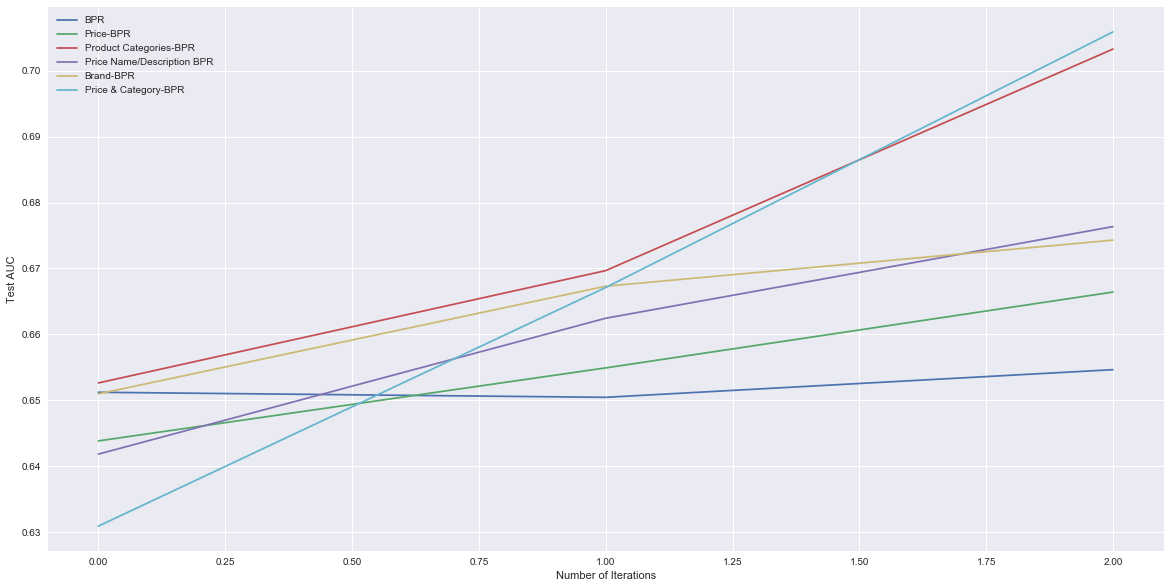

In [27]:
plt.figure(figsize=(20,10))
plt.plot(bpr_auc_test, label = "BPR")
plt.plot(pbpr_auc_test, label = "Price-BPR")
plt.plot(cbpr_auc_test,label="Product Categories-BPR")
plt.plot(pdbpr_auc_test, label = "Price Name/Description BPR")
plt.plot(bbpr_auc_test, label = "Brand-BPR")
plt.plot(pcatbpr_auc_test,label ="Price & Category-BPR")
plt.legend()
plt.ylabel("Test AUC")
plt.xlabel("Number of Iterations")


## comparing Cold Start Test AUC vs. number of iterations for different models

Text(0.5,0,'Number of Iterations')

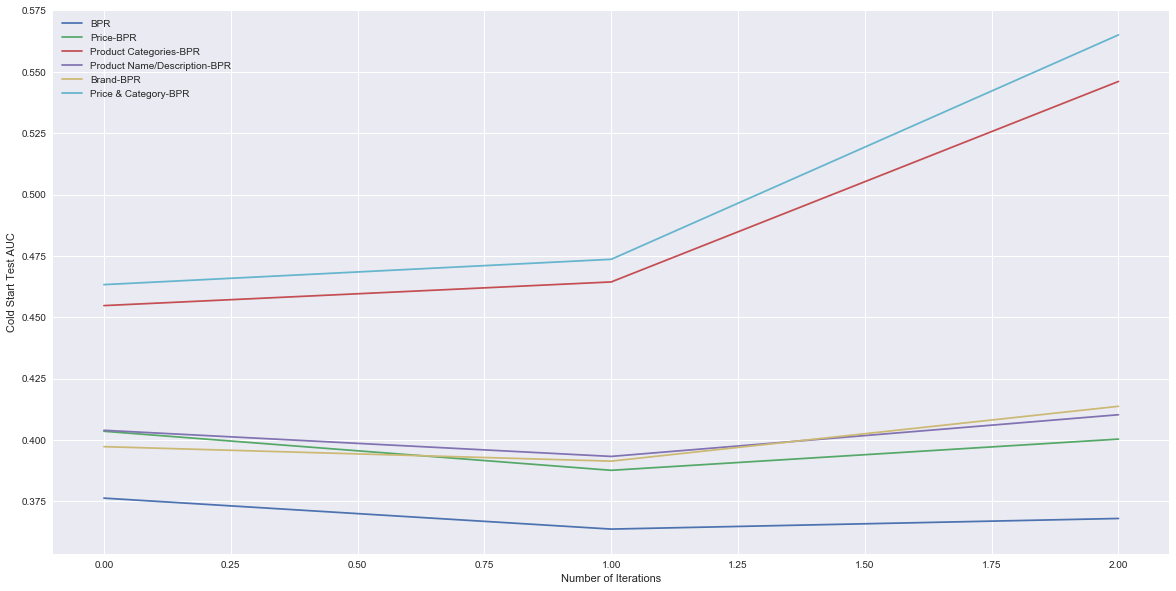

In [29]:
plt.figure(figsize=(20,10))
plt.plot(bpr_auc_test_cold_start, label = "BPR")
plt.plot(pbpr_auc_test_cold_start, label = "Price-BPR")
plt.plot(cbpr_auc_test_cold_start,label="Product Categories-BPR")
plt.plot(pdbpr_auc_test_cold_start, label = "Product Name/Description-BPR")
plt.plot(bbpr_auc_test_cold_start, label = "Brand-BPR")
plt.plot(pcatbpr_auc_test_cold_start,label ="Price & Category-BPR")
plt.legend()
plt.ylabel("Cold Start Test AUC")
plt.xlabel("Number of Iterations")


In [ ]:
#!pip install line_profiler
%load_ext line_profiler

In [34]:
%lprun -f session_run(NUM_SESSIONS, user_count, item_count, users, items, user_ratings, item_ratings, feature_set([loaded_features[c] for c in ['top_categories_hotencoded']]))

UsageError: Could not find function 'session_run(NUM_SESSIONS,'.
SyntaxError: unexpected EOF while parsing (<string>, line 1)


## Writing the results to a CSV file

In [ ]:
# import csv
# rows = zip(bpr_auc_test, pbpr_auc_test, bbpr_auc_test, pdbpr_auc_test, nvbpr_auc_test, vbpr_auc_test, 
#            hbpr_auc_test, bpr_auc_test_cold_start, pbpr_auc_test_cold_start, bbpr_auc_test_cold_start,
#           pdbpr_auc_test_cold_start, nvbpr_auc_test_cold_start, vbpr_auc_test_cold_start, hbpr_auc_test_cold_start)

# with open("AUC_5core_Women.csv", "wb") as f:
#     writer = csv.writer(f)
#     writer.writerow(["bpr_auc_test", "pbpr_auc_test", "bbpr_auc_test", "pdbpr_auc_test", "nvbpr_auc_test", 
#                      "vbpr_auc_test", "hbpr_auc_test", "bpr_auc_test_cold_start", "pbpr_auc_test_cold_start",
#                     "bbpr_auc_test_cold_start", "pdbpr_auc_test_cold_start", "nvbpr_auc_test_cold_start",
#                     "vbpr_auc_test_cold_start", "hbpr_auc_test_cold_start"])
#     for row in rows:
#         writer.writerow(row)